# Customer Segmentation - An application of K-Means clustering and RFM evaluation. 
In this notebook, I applied the RFM method to analysing customer value. 

The RFM method encapsulates three aspects of customer behaviour: 
* Recency – How recently did the customer purchase?
* Frequency – How often do they purchase?
* Monetary Value – How much do they spend?

I applied this to the "Online Retail" dataset found on kaggle: https://www.kaggle.com/vijayuv/onlineretail

To split the customers into different groupings based on their value in each aspect of RFM, I employed K-Means clustering. The clusters where then ranked in terms of how valuable they were (with 0 being the lowest and 4 being the highest). This allowed a total score, the sum of the customers cluster value in each RFM aspect, to be calculated. This gave an overall value rating for each customer which would allow for targeted advertising for the businesses involved. 

#### Imports

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

#### Cleaning and manipulating the data

In [2]:
df = pd.read_csv("OnlineRetail.csv", encoding="cp1252")

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [5]:
df.isnull().sum(axis = 0 )

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# Converting the string data to datetime:
df.InvoiceDate = pd.to_datetime(df.InvoiceDate, format = "%m/%d/%Y %H:%M").dt.date

In [7]:
# Given our analysis requires use of the Customer ID, customers without any ID will be dropped from the dataset. 
df = df[pd.notnull(df.CustomerID)]

In [8]:
# We want to deal with just the UK based customers: 
df = df.query("Country == 'United Kingdom'").reset_index(drop = True)

In [9]:
df = df[df.Quantity>0]
df = df[df.UnitPrice>0]

In [10]:
df.count()

InvoiceNo      354321
StockCode      354321
Description    354321
Quantity       354321
InvoiceDate    354321
UnitPrice      354321
CustomerID     354321
Country        354321
dtype: int64

## Recency 

Recency, as the name indicates, describes how recently the customer has purchased/interacted with the business. Customers who have recently interacted with the business are more likely to keep the business in mind and purchase there again. Identifying these customers allows the business to get in contact with the individual and gently remind them to revisit soon to continue to meet their purchase needs. 

In [11]:
user_df = pd.DataFrame(df.CustomerID.unique())
user_df.columns = ["CustomerID"]

In [12]:
most_recent_df = df.groupby('CustomerID').InvoiceDate.max().reset_index()
most_recent_df.columns = ["CustomerID", "MostRecentDate"]

# Find the Recency: The number of days since the last purchase (using the most recent date in the entire dataset as a benchmark)
most_recent_df["Recency"] = (most_recent_df.MostRecentDate.max() - most_recent_df.MostRecentDate).dt.days

In [13]:
user_df = pd.merge(user_df, most_recent_df[["CustomerID", "Recency"]], on = ["CustomerID"])
user_df.head()

,CustomerID,Recency
0,17850.0,372
1,13047.0,31
2,13748.0,95
3,15100.0,333
4,15291.0,25


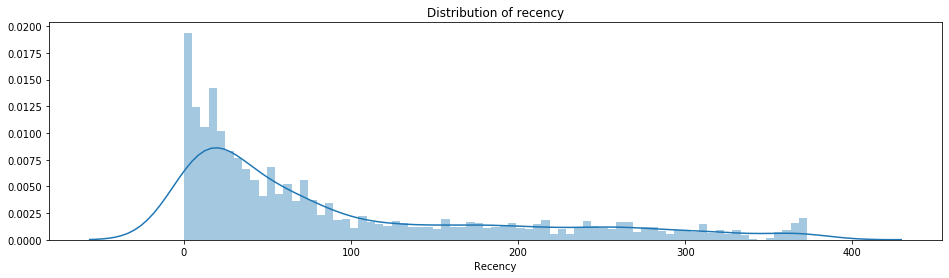

In [14]:
plt.figure(figsize = (16, 4))
sns.distplot(user_df.Recency, bins = 75, kde = True)
plt.title("Distribution of recency")
plt.show()

### Applying K Means Clustering

In [15]:
from sklearn.cluster import KMeans

In [16]:
sum_of_squared_distances = []
k_vals = range(1, 10)
recency = user_df.Recency
recency = recency.values.reshape(-1, 1)
for k in k_vals:
    KM = KMeans(n_clusters = k, random_state = 42).fit(recency)
    sum_of_squared_distances.append(KM.inertia_)

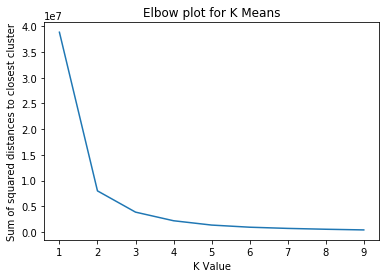

In [17]:
plt.figure()
plt.plot(k_vals, sum_of_squared_distances)
plt.xlabel("K Value")
plt.ylabel("Sum of squared distances to closest cluster")
plt.title("Elbow plot for K Means")
plt.show()

On the elbow plot, the optimal K value is found at the "elbow" of the plot (imagining the plot forms an arm). In this case, it appears to occur at 2 or 3. We shall use K = 3. 

In [18]:
def sort_clusters(df, column, cluster_column, descending = False):
    means = df.groupby(cluster_column)[column].mean().reset_index()
    cluster_vals = means[cluster_column].values
    means = means.sort_values(by = column)
    correct_order = means[cluster_column].values    
    df[cluster_column] = user_df[cluster_column].replace(correct_order, cluster_vals)
 
    if descending:     
        df[cluster_column] = user_df[cluster_column].replace(cluster_vals[::-1], cluster_vals)
    
    return df

In [19]:
k_val = 5

In [20]:
km = KMeans(n_clusters = k_val, random_state = 42)
km.fit(user_df[["Recency"]])
user_df["RecencyCluster"] = km.predict(user_df[["Recency"]])


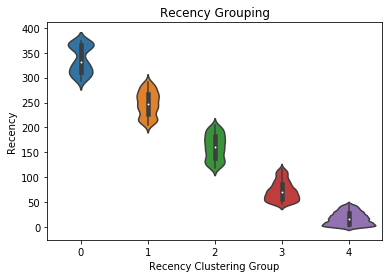

In [21]:
user_df = sort_clusters(user_df, "Recency", "RecencyCluster", descending = True)
sns.violinplot(user_df["RecencyCluster"], user_df["Recency"])
plt.title("Recency Grouping")
plt.xlabel("Recency Clustering Group")
plt.show()

In [22]:
user_df.describe()

,CustomerID,Recency,RecencyCluster
count,3920.000000,3920.000000,3920.000000
mean,15562.059694,91.742092,2.964031
std,1576.594671,99.533485,1.255956
min,12346.000000,0.000000,0.000000
25%,14208.750000,17.000000,2.000000
50%,15569.500000,50.000000,3.000000
75%,16913.250000,142.000000,4.000000
max,18287.000000,373.000000,4.000000


## Frequency

Frequency is simply defined as how often a customer purchased or interacted with a business. This can be calculated from the data through counting the number of invoices associated with each customer. 

In [23]:
frequency_df = df.groupby("CustomerID").InvoiceNo.count().reset_index()
frequency_df.columns = ["CustomerID", "InvoiceCount"]
frequency_df = pd.merge(frequency_df, most_recent_df[["CustomerID", "MostRecentDate"]], on="CustomerID")
least_recent_df = df.groupby('CustomerID').InvoiceDate.min().reset_index()
least_recent_df.columns = ["CustomerID", "LeastRecentDate"]
frequency_df = pd.merge(frequency_df, least_recent_df, on="CustomerID")

In [24]:
frequency_df["CustomerDuration"] = (frequency_df["MostRecentDate"] - frequency_df["LeastRecentDate"]).dt.days
frequency_df["Frequency"] = np.where(frequency_df["CustomerDuration"] == 0, 0, frequency_df["InvoiceCount"]/frequency_df["CustomerDuration"])

In [25]:
user_df = pd.merge(user_df, frequency_df[["CustomerID", "Frequency"]], on = "CustomerID")
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,372,0,297.000000
1,13047.0,31,4,0.502924
2,13748.0,95,3,0.100719
3,15100.0,333,0,0.075000
4,15291.0,25,4,0.295977


In [26]:
user_df.Frequency.describe()

count    3920.000000
mean        0.763525
std         6.225084
min         0.000000
25%         0.000000
50%         0.199109
75%         0.578398
max       297.000000
Name: Frequency, dtype: float64

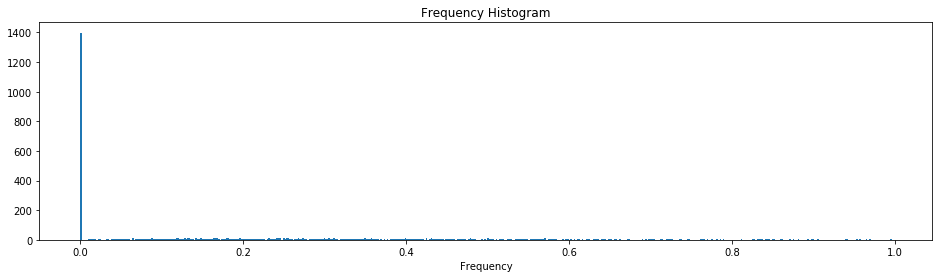

In [27]:
plt.figure(figsize = (16, 4))
plt.hist(user_df[user_df.Frequency < 1].Frequency, bins = 500)
plt.title("Frequency Histogram")
plt.xlabel("Frequency")
plt.show()

In [28]:
km = KMeans(n_clusters = k_val, random_state = 42)
km.fit(user_df[["Frequency"]])
user_df["FrequencyCluster"] = km.predict(user_df[["Frequency"]])

In [29]:
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,17850.0,372,0,297.000000,2
1,13047.0,31,4,0.502924,0
2,13748.0,95,3,0.100719,0
3,15100.0,333,0,0.075000,0
4,15291.0,25,4,0.295977,0


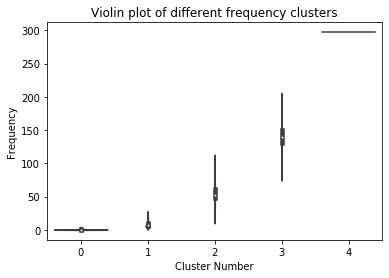

In [30]:
user_df = sort_clusters(user_df, "Frequency", "FrequencyCluster")
sns.violinplot(user_df.FrequencyCluster, user_df.Frequency)
plt.xlabel("Cluster Number")
plt.title("Violin plot of different frequency clusters")
plt.show()

In [31]:
user_df.count()

CustomerID          3920
Recency             3920
RecencyCluster      3920
Frequency           3920
FrequencyCluster    3920
dtype: int64

In [32]:
print(user_df[user_df.Frequency == 0].Frequency.count())

1398


## Monetary Value

Monetary value relates to how much the customer is actually spending. The dataset here gives the price of the unit bought as well as how many units were purchased. Therefore it is a simple piece of multiplication to work out how much the individual has spent on any single invoice. The total for each invoice can be summed for each customer to find the total amount that they have spent. 

In [33]:
df["Revenue"] = df.UnitPrice * df.Quantity
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850.0,United Kingdom,20.34


In [34]:
monetary_df = df.groupby("CustomerID").Revenue.mean().reset_index()
monetary_df.columns = ["CustomerID", "MonetaryValue"]

user_df = pd.merge(user_df, monetary_df, on = "CustomerID")
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,MonetaryValue
0,17850.0,372,0,297.000000,4,18.152222
1,13047.0,31,4,0.502924,0,18.822907
2,13748.0,95,3,0.100719,0,33.866071
3,15100.0,333,0,0.075000,0,292.000000
4,15291.0,25,4,0.295977,0,45.323301


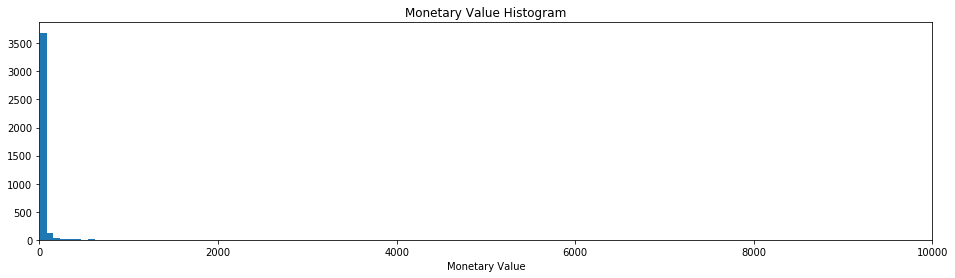

In [35]:
plt.figure(figsize = (16, 4))
plt.hist(user_df["MonetaryValue"], bins = 1000)
plt.title("Monetary Value Histogram")
plt.xlabel("Monetary Value")
plt.xlim(0, 10000)
plt.show()

In [36]:
km = KMeans(n_clusters = k_val, random_state = 42)
km.fit(user_df[["MonetaryValue"]])
user_df["MonetaryCluster"] = km.predict(user_df[["MonetaryValue"]])

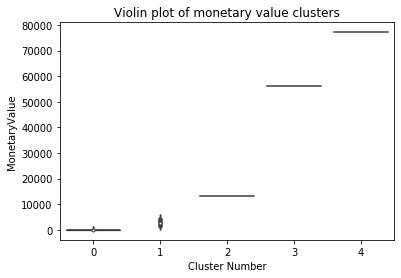

In [37]:
user_df = sort_clusters(user_df, "MonetaryValue", "MonetaryCluster")
sns.violinplot(user_df.MonetaryCluster, user_df.MonetaryValue )
plt.xlabel("Cluster Number")
plt.title("Violin plot of monetary value clusters")
plt.show()

In [38]:
user_df["OverallScore"] = user_df.RecencyCluster + user_df.FrequencyCluster + user_df.MonetaryCluster

In [39]:
user_df.groupby("OverallScore")[["Recency", "Frequency", "MonetaryValue"]].describe()

Recency                                                     \
               count        mean        std    min    25%    50%    75%   
OverallScore                                                              
0              249.0  336.112450  27.220045  294.0  311.0  331.0  365.0   
1              390.0  248.379487  25.168422  205.0  226.0  249.0  267.0   
2              465.0  161.664516  25.907148  119.0  138.0  162.0  184.0   
3              932.0   73.787554  20.969364   46.0   58.0   71.0   87.0   
4             1826.0   18.779299  17.867673    0.0    7.0   17.0   29.0   
5               52.0   15.288462  14.592956    0.0    3.0    8.5   24.0   
6                3.0    4.666667   4.041452    1.0    2.5    4.0    6.5   
7                3.0    8.333333   8.504901    0.0    4.0    8.0   12.5   

                    Frequency             ...                          \
                max     count       mean  ...         75%         max   
OverallScore                              ...                           
0             373.0     249.0   0.168584  ...    0.000000    3.500000   
1             360.0     390.0   0.152462  ...    0.000000    4.750000   
2             239.0     465.0   0.389633  ...    0.426396   23.000000   
3             198.0     932.0   0.354059  ...    0.426201   15.000000   
4             372.0    1826.0   0.811123  ...    0.773954  297.000000   
5              57.0      52.0   9.262698  ...    9.251337   61.000000   
6               9.0       3.0  45.878389  ...   50.567583   52.690722   
7              17.0       3.0  93.338211  ...  140.000000  159.000000   

             MonetaryValue                                                   \
                     count          mean           std       min        25%   
OverallScore                                                                  
0                    249.0     38.692904     93.796774  2.101286  11.553684   
1                    390.0     32.156272     67.844560  2.241000  13.034099   
2                    465.0     42.500967    215.088077  2.656932  11.693852   
3                    932.0     33.535147    112.471664  2.547049  13.789294   
4                   1826.0     79.865296   1834.170669  2.150588  10.065947   
5                     52.0    115.771250    578.456984  2.432500   4.730492   
6                      3.0     10.738377      7.431307  2.508372   7.629141   
7                      3.0  18737.692066  32406.514139  2.504876  27.788098   

                                                     
                    50%           75%           max  
OverallScore                                         
0             16.918788     27.621429   1001.200000  
1             17.282115     24.840920    931.500000  
2             17.624444     24.737500   4453.430000  
3             18.182987     26.553017   3096.000000  
4             17.129960     23.190674  77183.600000  
5              6.459703     10.276910   3861.000000  
6             12.749910     14.853380     16.956849  
7             53.071321  28105.285660  56157.500000  

[8 rows x 24 columns]

Say that based on the overall scores, customer's value to the business can be ranked: 
* 0 - 2 = Low Value
* 3 - 5 = Mid Value
* 6 - 8 = High Value

In [40]:
user_df["UserValue"] = 0
user_df.loc[user_df["OverallScore"] > 2, "UserValue"] = 1
user_df.loc[user_df["OverallScore"] > 5, "UserValue"] = 2

In [41]:
user_df.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,MonetaryValue,MonetaryCluster,OverallScore,UserValue
0,17850.0,372,0,297.000000,4,18.152222,0,4,1
1,13047.0,31,4,0.502924,0,18.822907,0,4,1
2,13748.0,95,3,0.100719,0,33.866071,0,3,1
3,15100.0,333,0,0.075000,0,292.000000,0,0,0
4,15291.0,25,4,0.295977,0,45.323301,0,4,1


In [42]:
low_value_df = user_df.query("UserValue == 0").reset_index(drop = True)
mid_value_df = user_df.query("UserValue == 1").reset_index(drop = True)
high_value_df = user_df.query("UserValue == 2").reset_index(drop = True)

In [43]:
print("Low Value: ", len(low_value_df))
print("Mid Value: ", len(mid_value_df))
print("High Value: ", len(high_value_df))

Low Value:  1104
Mid Value:  2810
High Value:  6


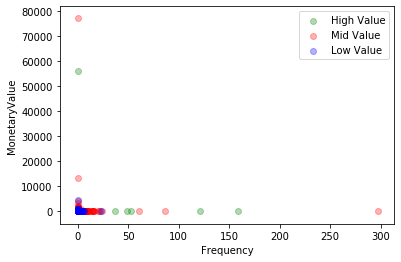

In [44]:
plt.figure()
x_axis = "Frequency"
y_axis = "MonetaryValue"
plt.scatter(high_value_df[x_axis], high_value_df[y_axis], c = 'g', alpha = 0.3, label = "High Value", zorder = 3)
plt.scatter(mid_value_df[x_axis], mid_value_df[y_axis], c = 'r', alpha = 0.3, label = "Mid Value", zorder = 2)
plt.scatter(low_value_df[x_axis], low_value_df[y_axis], c = 'b', alpha = 0.3, label = "Low Value", zorder = 4)
plt.legend()
plt.ylabel(y_axis)
plt.xlabel(x_axis)
plt.show()

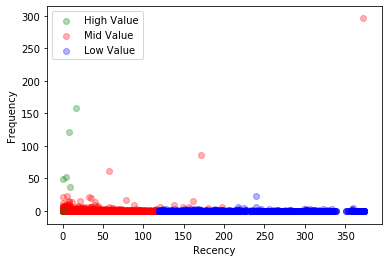

In [45]:
plt.figure()
x_axis = "Recency"
y_axis = "Frequency"
plt.scatter(high_value_df[x_axis], high_value_df[y_axis], c = 'g', alpha = 0.3, label = "High Value", zorder = 3)
plt.scatter(mid_value_df[x_axis], mid_value_df[y_axis], c = 'r', alpha = 0.3, label = "Mid Value", zorder = 2)
plt.scatter(low_value_df[x_axis], low_value_df[y_axis], c = 'b', alpha = 0.3, label = "Low Value", zorder = 4)
plt.legend()
plt.ylabel(y_axis)
plt.xlabel(x_axis)
plt.show()

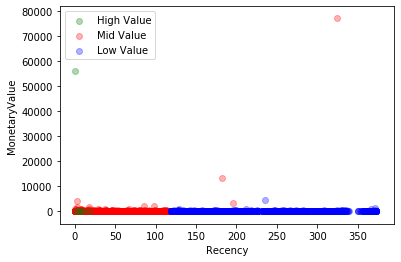

In [46]:
plt.figure()
x_axis = "Recency"
y_axis = "MonetaryValue"
plt.scatter(high_value_df[x_axis], high_value_df[y_axis], c = 'g', alpha = 0.3, label = "High Value", zorder = 3)
plt.scatter(mid_value_df[x_axis], mid_value_df[y_axis], c = 'r', alpha = 0.3, label = "Mid Value", zorder = 2)
plt.scatter(low_value_df[x_axis], low_value_df[y_axis], c = 'b', alpha = 0.3, label = "Low Value", zorder = 4)
plt.legend()
plt.ylabel(y_axis)
plt.xlabel(x_axis)
plt.show()

In [47]:
from mpl_toolkits import mplot3d

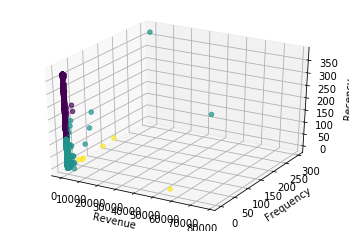

In [48]:
ax = plt.axes(projection='3d')
ax.scatter3D(user_df["MonetaryValue"], user_df["Frequency"], user_df["Recency"], c= user_df["UserValue"], alpha = 0.7)
ax.set_xlabel("Revenue")
ax.set_ylabel("Frequency")
ax.set_zlabel("Recency")

#ax.set_xlim(0, 10000)
#ax.set_ylim(0, 1500)
plt.show()

In [49]:
pairwise_df = user_df[["Recency", "Frequency", "MonetaryValue", "UserValue"]]
pairwise_df.loc[pairwise_df["UserValue"] == 0, "UserValue"] = "Low Value"
pairwise_df.loc[pairwise_df["UserValue"] == 1, "UserValue"] = "Mid Value"
pairwise_df.loc[pairwise_df["UserValue"] == 2, "UserValue"] = "High Value"


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
user_df.MonetaryValue.describe()

count     3920.000000
mean        71.758320
std       1543.980073
min          2.101286
25%         11.192679
50%         17.284962
75%         24.393523
max      77183.600000
Name: MonetaryValue, dtype: float64

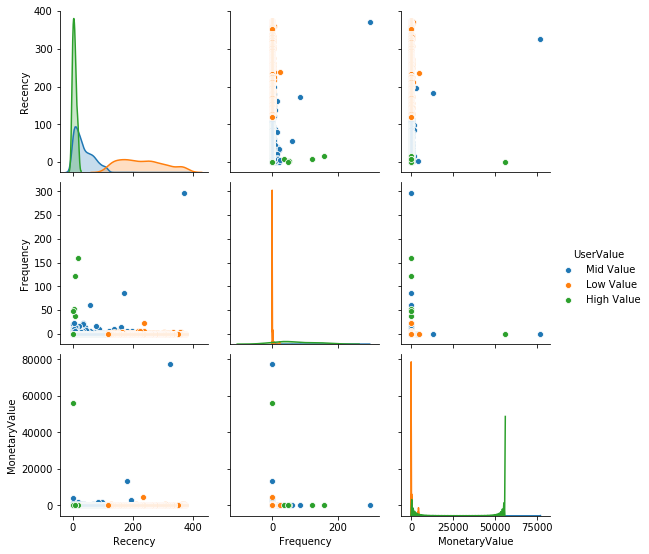

In [51]:
sns.pairplot(pairwise_df, hue="UserValue")
plt.show()

In [52]:
test_df = sns.load_dataset("iris")

In [53]:
test_df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
